In [2]:
import os
import os.path as op
import pandas as pd




In [3]:
def load_data():
    scenes_dir = '/home/hyruuk/GitHub/neuromod/mario_data/mario/code/annotations/scenes'
    scenes_mastersheet = op.join(scenes_dir, 'resources', 'scenes_mastersheet.tsv')
    scenes_df = pd.read_csv(scenes_mastersheet, sep='\t')
    scenes_df['scene_ID'] = scenes_df.apply(
        lambda row: f"w{int(row['World'])}l{int(row['Level'])}s{int(row['Scene'])}",
        axis=1
    )
    scenes_df = scenes_df.drop(columns=['World', 'Level', 'Scene', 
                            'x Hi (entry)', 'x Lo (entry)',
                            'x Hi (exit)', 'x Lo (exit)', 
                            'Entry point', 'Exit point', 
                            'Layout'])
    return scenes_df

scenes_df = load_data()
scenes_df

Enemy  2-Horde  3-Horde  4-Horde  Roof  Gap  Multiple gaps  \
0        0        0        0        0     0    0              0   
1        1        0        0        0     0    0              0   
2        0        0        0        0     0    0              0   
3        1        0        0        0     0    0              0   
4        0        1        0        0     0    0              0   
..     ...      ...      ...      ...   ...  ...            ...   
308      0        0        0        0     0    0              0   
309      1        0        0        0     0    0              0   
310      1        0        0        0     0    0              0   
311      0        0        0        0     0    0              0   
312      0        0        0        0     0    0              1   

     Variable gaps  Gap enemy  Pillar gap  ...  Empty stair valley  \
0                0          0           0  ...                   0   
1                0          0           0  ...                   0   
2                0          0           0  ...                   0   
3                0          0           0  ...                   0   
4                0          0           0  ...                   0   
..             ...        ...         ...  ...                 ...   
308              0          0           1  ...                   0   
309              0          0           0  ...                   0   
310              0          0           0  ...                   0   
311              0          0           0  ...                   0   
312              0          0           0  ...                   0   

     Enemy stair valley  Gap stair valley  Reward  Moving platform  Flagpole  \
0                     0                 0       0                0         0   
1                     0                 0       0                0         0   
2                     0                 0       0                0         0   
3                     0                 0       0                0         0   
4                     0                 0       0                0         0   
..                  ...               ...     ...              ...       ...   
308                   0                 0       0                0         0   
309                   0                 0       0                0         0   
310                   0                 0       0                0         0   
311                   0                 0       0                0         0   
312                   0                 0       0                0         1   

     Beginning  Bonus zone  Waterworld  scene_ID  
0            1           0           0    w1l1s0  
1            0           0           0    w1l1s1  
2            0           0           0    w1l1s2  
3            0           0           0    w1l1s3  
4            0           0           0    w1l1s4  
..         ...         ...         ...       ...  
308          0           0           0    w8l3s7  
309          0           0           0    w8l3s8  
310          0           0           0    w8l3s9  
311          0           0           0   w8l3s10  
312          0           0           0   w8l3s11  

[313 rows x 30 columns]

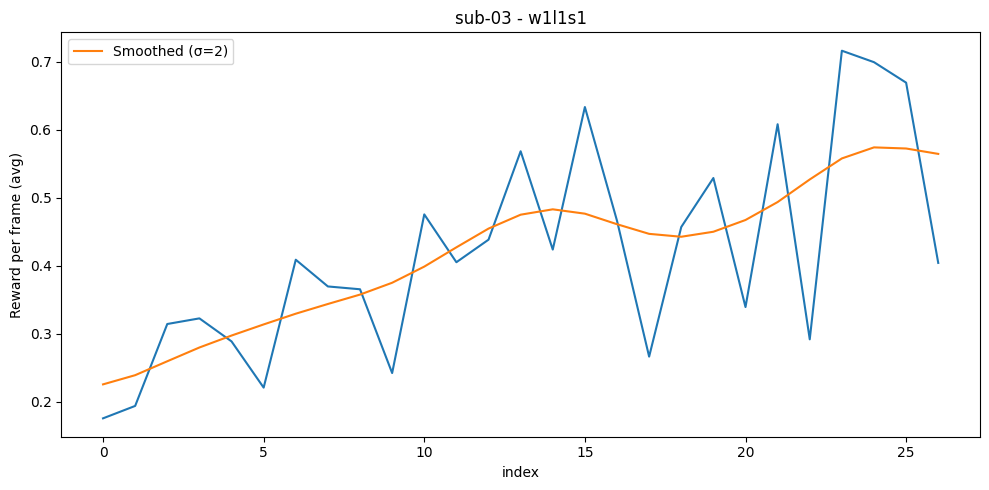

In [297]:
import json
import scipy.stats


def load_clips_metadata(clips_json_folder, subject, scene_id, zscore=False, sort=True):

    scene_id_str = f"level-{scene_id.split('s')[0]}_scene-{scene_id.split('s')[1]}_"

    clip_codes = []
    clip_durations = []
    clip_rewards = []
    clip_cleareds = []
    for root, dirs, files in os.walk(op.join(clips_json_folder, subject)):
        for file in files:
            if scene_id_str in file and file.endswith('.json'):
                # Load the json file and get info
                with open(op.join(root, file), 'r') as f:
                    data = json.load(f)
                    clip_codes.append(data['ClipCode'])
                    clip_durations.append(data['TotalFrames'])
                    clip_rewards.append(data['Reward'])
                    clip_cleareds.append(data['Cleared'])
    if zscore:
        clip_durations = list(scipy.stats.zscore(clip_durations))
        clip_rewards = list(scipy.stats.zscore(clip_rewards))
    clips_df = pd.DataFrame({
        'clip_code': clip_codes,
        'speed': [-x for x in clip_durations],
        'duration': clip_durations,
        'reward': clip_rewards,
        'cleared': clip_cleareds,
        'scene_id': scene_id
    })

    if sort:
        clips_df.sort_values(by='clip_code', ascending=True, inplace=True)
        clips_df.reset_index(drop=True, inplace=True)
        clips_df.reset_index(drop=False, inplace=True)

    return clips_df


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

def basic_learning_plot(clips_df, subject, scene_or_pattern_id, smoothing=None, ax=None):
    """
    Plots 'reward' versus 'index' on the given Ax (if provided),
    otherwise creates a new figure/ax.
    """
    create_new_fig = (ax is None)
    if create_new_fig:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
    else:
        # If an external Ax is provided, we can still retrieve the figure from it
        fig = ax.figure

    # Plot raw data
    sns.lineplot(data=clips_df, x='index', y='reward', ax=ax, label='_nolegend_')

    # Optional smoothing
    if smoothing is not None and smoothing > 0:
        df_smoothed = clips_df.copy()
        df_smoothed['reward'] = gaussian_filter1d(df_smoothed['reward'].values, sigma=smoothing)
        sns.lineplot(data=df_smoothed, x='index', y='reward', ax=ax, label=f'Smoothed (σ={smoothing})')

        # Show legend only if smoothing is used
        ax.legend()

    ax.set_title(f'{subject} - {scene_or_pattern_id}')
    ax.set_ylabel('Reward per frame (avg)')

    if create_new_fig:
        #fig.suptitle(f'Learning curve of {subject} {scene_or_pattern_id}')
        fig.tight_layout()
        return fig, ax
    else:
        return ax

clips_json_folder = '/home/hyruuk/GitHub/neuromod/mario_data/mario/derivatives/scenes_simple'

subject = 'sub-03'
scene_id = 'w1l1s1'
clips_df = load_clips_metadata(clips_json_folder, subject, scene_id, zscore=False)
fig, ax = basic_learning_plot(clips_df, subject, scene_id, smoothing=2)

In [298]:
clips_df

index       clip_code  speed  duration    reward  cleared scene_id
0       0  00101000000573  -6646      6646  0.175252     True   w1l1s1
1       1  00101010000293  -5079      5079  0.193517     True   w1l1s1
2       2  00101020000568  -9120      9120  0.314042     True   w1l1s1
3       3  00101030000296  -7234      7234  0.322321     True   w1l1s1
4       4  00101040000307  -5270      5270  0.288462    False   w1l1s1
5       5  00101040000906  -5270      5270  0.220451     True   w1l1s1
6       6  00101050000288  -6310      6310  0.408610     True   w1l1s1
7       7  01002030000556  -3905      3905  0.369295     True   w1l1s1
8       8  01301000000316  -3212      3212  0.365149     True   w1l1s1
9       9  01303040000268  -6360      6360  0.241883     True   w1l1s1
10     10  01402040000512  -4136      4136  0.475303     True   w1l1s1
11     11  01502020000304  -3674      3674  0.404940     True   w1l1s1
12     12  01601020000290  -4890      4890  0.438103     True   w1l1s1
13     13  01801000000559  -4575      4575  0.568182     True   w1l1s1
14     14  01903010000292  -5814      5814  0.423557     True   w1l1s1
15     15  01903050000615  -5373      5373  0.633257     True   w1l1s1
16     16  02101040000393  -5919      5919  0.465928     True   w1l1s1
17     17  02102030000271  -6003      6003  0.266064     True   w1l1s1
18     18  02203030000563  -4451      4451  0.456739     True   w1l1s1
19     19  02401000000337  -4000      4000  0.528827     True   w1l1s1
20     20  02502020000278  -4682      4682  0.338972     True   w1l1s1
21     21  02505030000572  -5172      5172  0.607930     True   w1l1s1
22     22  02601040000318  -5374      5374  0.291485     True   w1l1s1
23     23  02704030000601  -5100      5100  0.716113     True   w1l1s1
24     24  02802050000580  -4638      4638  0.699248     True   w1l1s1
25     25  02902060000591  -5256      5256  0.669118     True   w1l1s1
26     26  02903050000566  -4470      4470  0.403933     True   w1l1s1

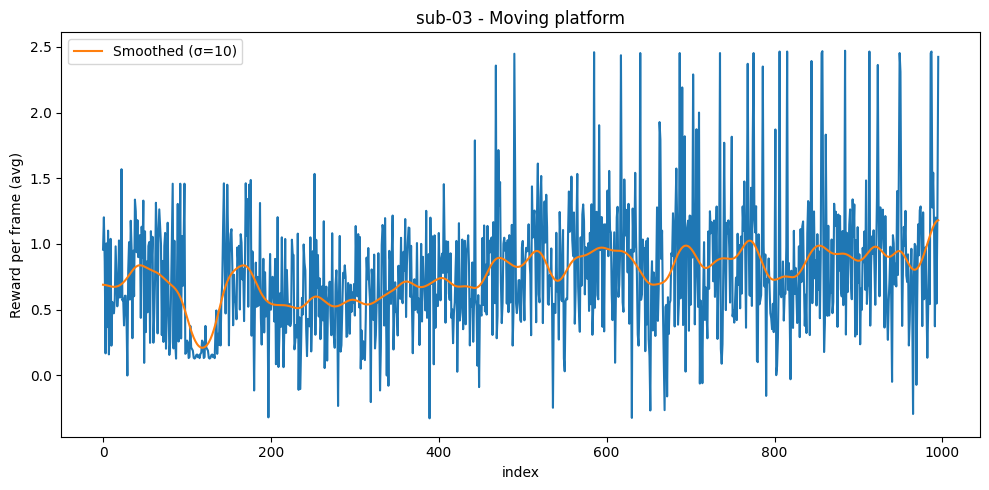

In [300]:
def load_pattern_metadata(patterns_json_folder, subject, pattern):
    scenes_with_pattern = []
    for _, row in scenes_df.iterrows():
        if row[pattern] == 1:
            scenes_with_pattern.append(row['scene_ID'])

    pattern_dflist = []
    for scene_id in scenes_with_pattern:
        clips_df = load_clips_metadata(patterns_json_folder, subject, scene_id, zscore=False, sort=False)
        if not clips_df.empty:
            pattern_dflist.append(clips_df)

    if not pattern_dflist:
        return pd.DataFrame()

    pattern_df = pd.concat(pattern_dflist, ignore_index=True)
    pattern_df.sort_values(by='clip_code', ascending=True, inplace=True)
    pattern_df.reset_index(drop=True, inplace=True)
    pattern_df.reset_index(drop=False, inplace=True)

    return pattern_df

subject = 'sub-03'
pattern = 'Moving platform'

pattern_df = load_pattern_metadata(clips_json_folder, subject, pattern)
fig, ax = basic_learning_plot(pattern_df, subject, pattern, smoothing=10)

In [304]:
pattern_formatted = pattern.replace(' ', '-')
pattern_df.to_csv(f'{pattern_formatted}_clips_metadata.csv', index=False)
pattern_df

index       clip_code  speed  duration    reward  cleared scene_id
0        0  00102000012525 -14399     14399  0.956204     True   w1l2s9
1        1  00102000012799 -14399     14399  1.202335     True  w1l2s10
2        2  00102010004918 -10370     10370  0.866221     True   w1l2s9
3        3  00102010005217 -10370     10370  0.165901     True  w1l2s10
4        4  00102020005550  -8035      8035  1.003846     True   w1l2s9
..     ...             ...    ...       ...       ...      ...      ...
991    991  03003030002074  -4456      4456  0.371963     True   w3l3s7
992    992  03003030003601  -4456      4456  1.200000     True  w3l3s10
993    993  03003060001729  -4397      4397  0.545310     True   w1l3s4
994    994  03003060002783  -4397      4397  1.212687     True   w1l3s6
995    995  03003060003445  -4397      4397  2.424242     True   w1l3s9

[996 rows x 7 columns]

'Moving-platform'

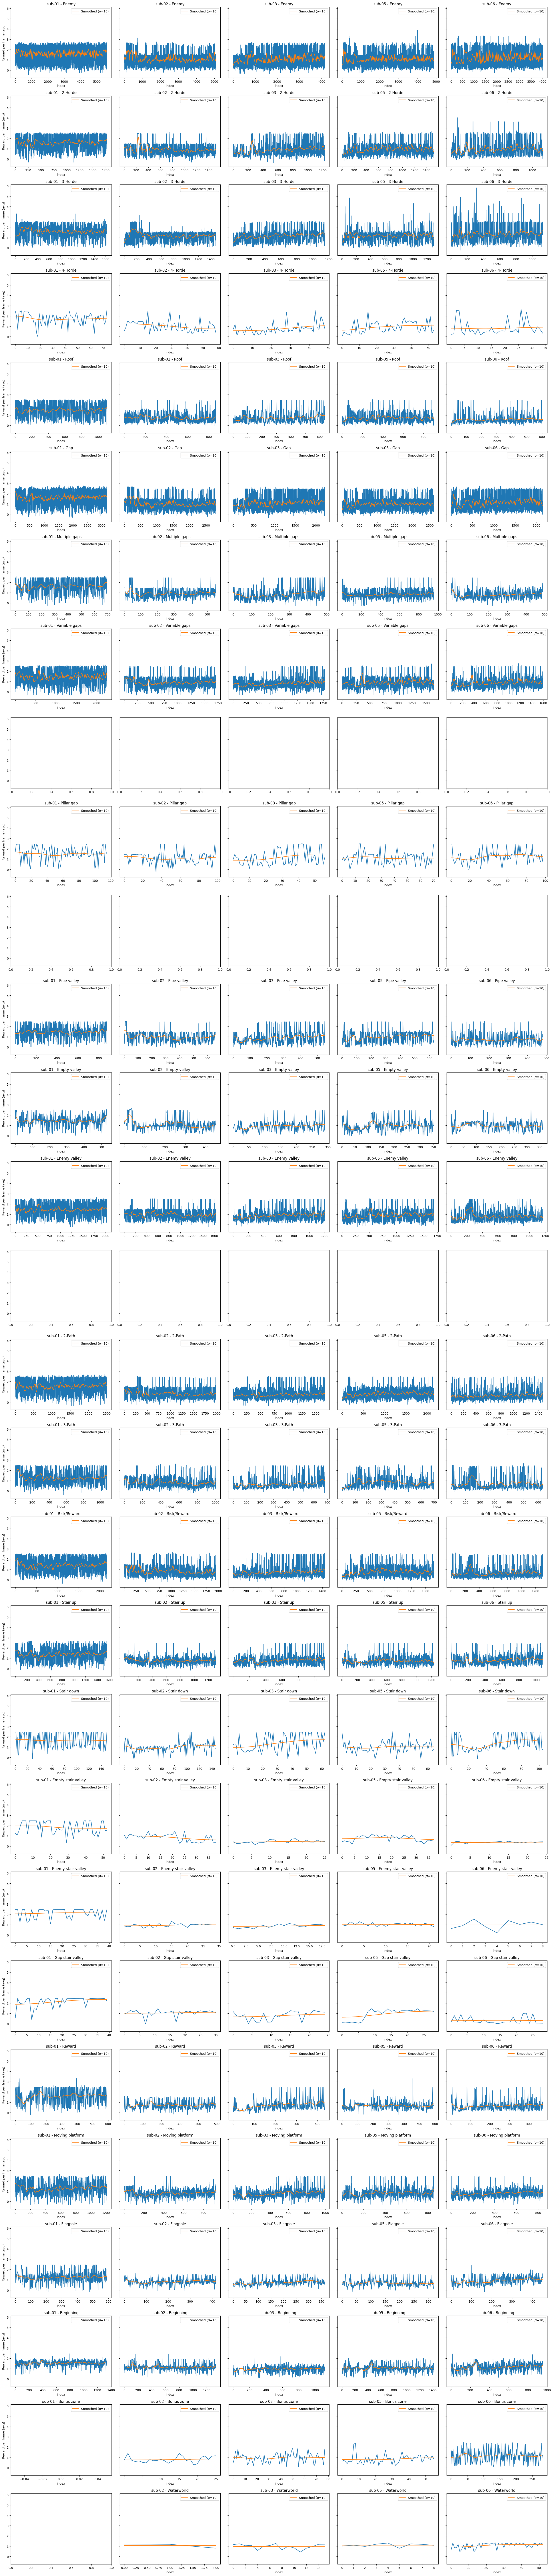

In [295]:
patterns = scenes_df.drop(columns=['scene_ID']).keys()  
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06']

nrows = len(patterns)
ncols = len(subjects)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharey=True)

for i, pattern in enumerate(patterns):
    for j, subject in enumerate(subjects):
        ax = axes[i, j]  # Select the subplot for (i, j)
        
        # Load data
        pattern_df = load_pattern_metadata(clips_json_folder, subject, pattern)
        if pattern_df.empty:
            continue

        # Plot into the existing Ax
        basic_learning_plot(
            pattern_df,
            subject,
            pattern,
            smoothing=10,   # Adjust as needed
            ax=ax
        )



plt.tight_layout()
plt.show()


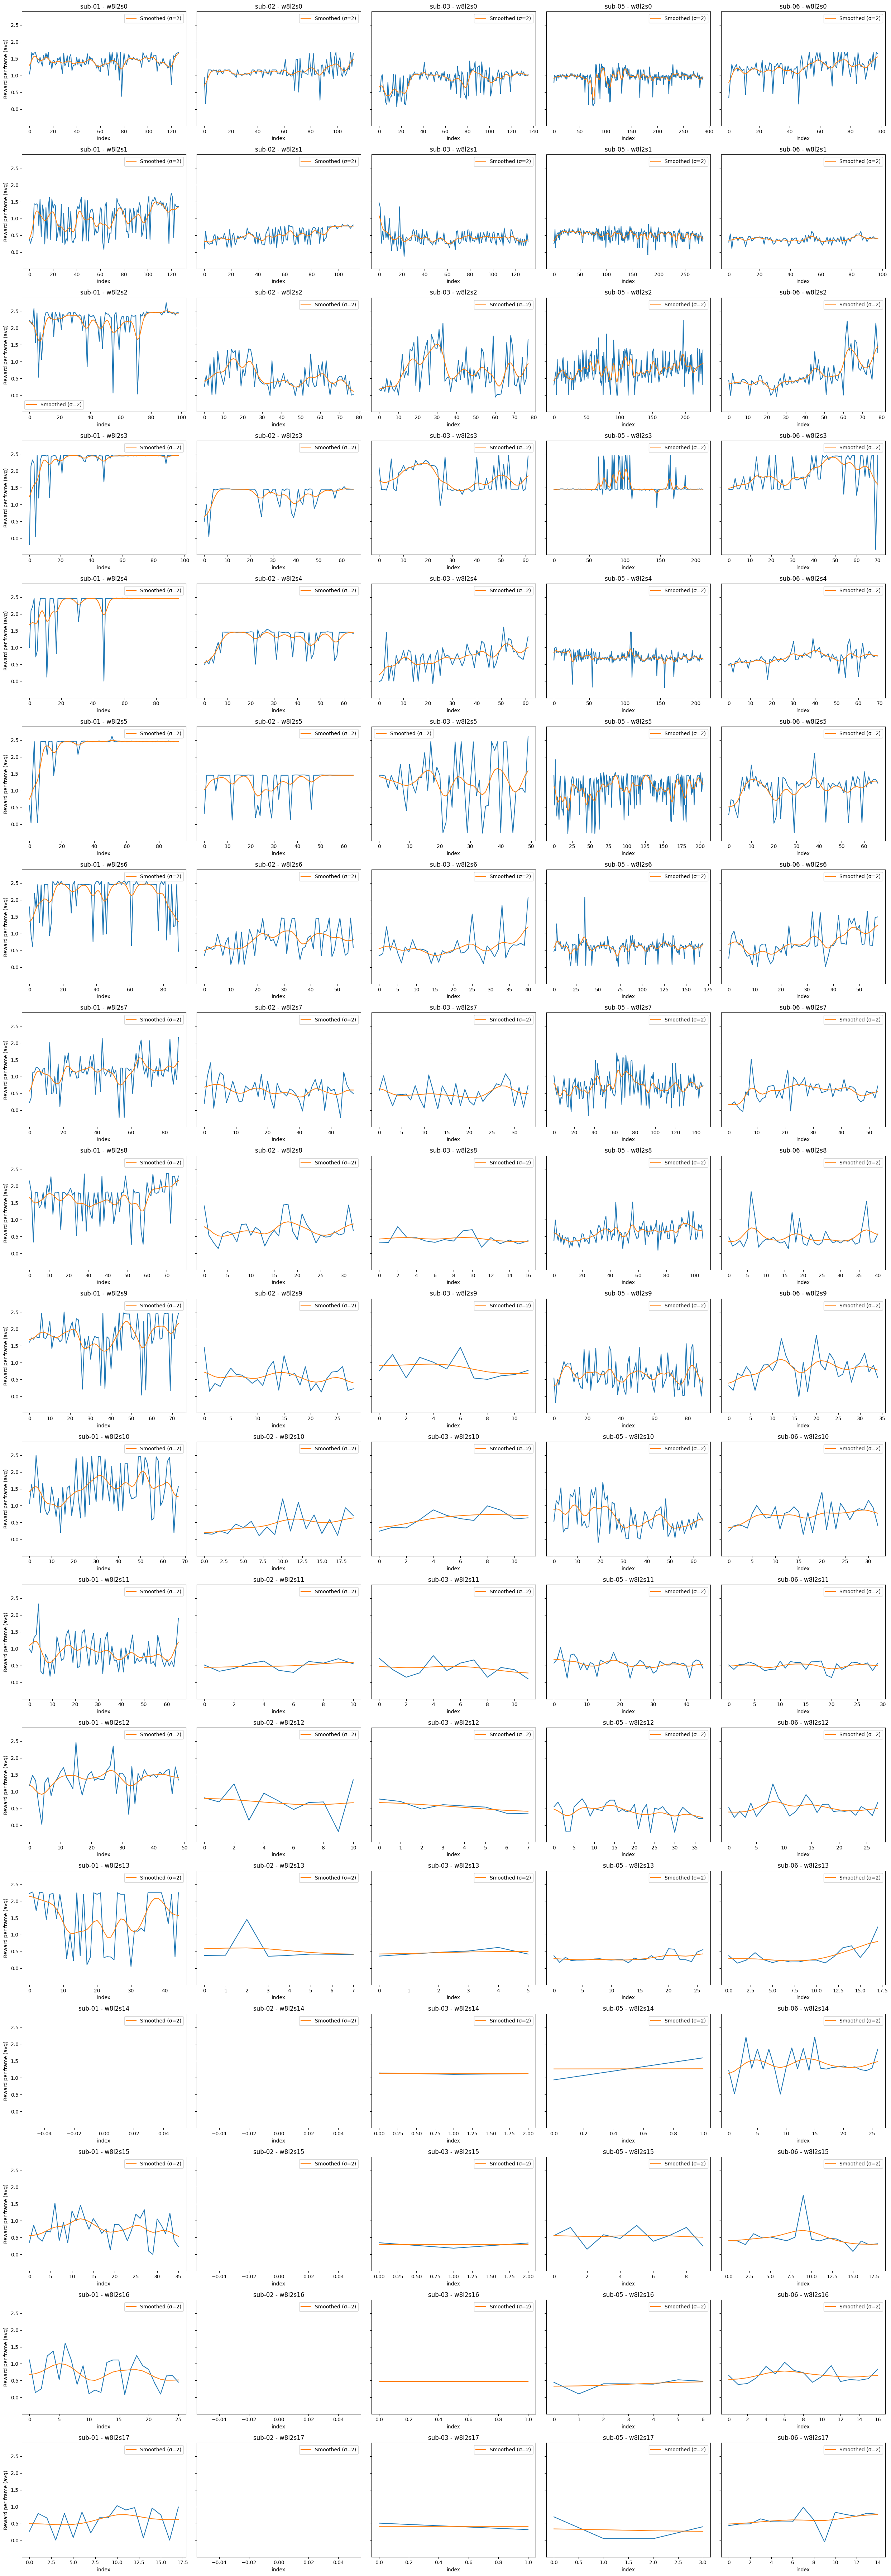

In [278]:
scene_id_list = scenes_df['scene_ID']
selected_level = 'w8l2'
scene_id_list = [scene_id for scene_id in scene_id_list if scene_id.startswith(f'{selected_level}')]

subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06']



nrows = len(scene_id_list)
ncols = len(subjects)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharey=True)

for i, scene_id in enumerate(scene_id_list):
    for j, subject in enumerate(subjects):
        ax = axes[i, j]  # Select the subplot for (i, j)
        
        # Load data
        pattern_df = load_clips_metadata(clips_json_folder, subject, scene_id, zscore=False, sort=True)

        # Plot into the existing Ax
        basic_learning_plot(
            pattern_df,
            subject,
            scene_id,
            smoothing=2,   # Adjust as needed
            ax=ax
        )

plt.tight_layout()
plt.show()


In [197]:
scenes_df.keys()

Index(['Enemy', '2-Horde', '3-Horde', '4-Horde', 'Roof', 'Gap',
       'Multiple gaps', 'Variable gaps', 'Gap enemy', 'Pillar gap', 'Valley',
       'Pipe valley', 'Empty valley', 'Enemy valley', 'Roof valley', '2-Path',
       '3-Path', 'Risk/Reward', 'Stair up', 'Stair down', 'Empty stair valley',
       'Enemy stair valley', 'Gap stair valley', 'Reward', 'Moving platform',
       'Flagpole', 'Beginning', 'Bonus zone', 'Waterworld', 'scene_ID'],
      dtype='object')

<Axes: xlabel='index', ylabel='reward'>

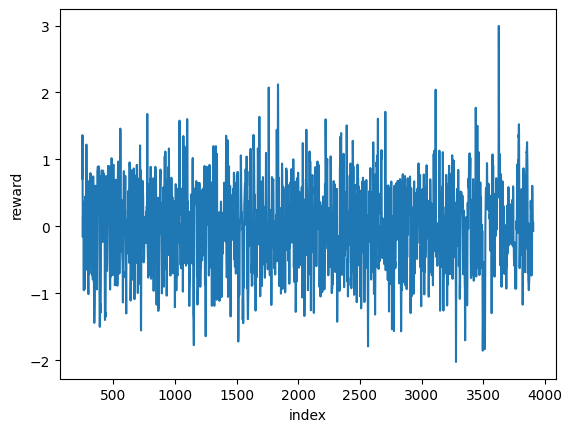

In [1]:


import pickle

clusters_file = '../data/clusters.pkl'

with open(clusters_file, 'rb') as f:
    clusters = pickle.load(f)
clusters

{0: {'index': array([0, 1, 1, 1, 0, 2, 2, 2, 2, 2, 3, 0, 0, 1, 3, 1, 1, 1, 0, 2, 2, 1,
         0, 0, 2, 2, 3, 0, 0, 4, 4, 2, 4, 4, 4, 0, 3, 4, 3, 0, 3, 1, 0, 2,
         1, 0, 0, 2, 0, 2, 1, 2, 2, 1, 4, 0, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
         2, 3, 2, 3, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 2, 3, 2, 0, 0, 0, 1,
         1, 1, 2, 2, 3, 2, 0, 0, 2, 3, 0, 2, 4, 1, 2, 4, 4, 4, 2, 0, 4, 0,
         2, 2, 2, 1, 1, 1, 2, 0, 4, 2, 3, 4, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3,
         2, 1, 3, 3, 1, 3, 0, 0, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 0, 2, 0, 2,
         2, 0, 2, 2, 2, 0, 2, 0, 2, 3, 0, 3, 2, 3, 2, 0, 4, 0, 2, 2, 2, 0,
         2, 1, 3, 0, 4, 3, 2, 4, 4, 4, 4, 4, 4, 3, 0, 2, 4, 2, 3, 3, 2, 3,
         3, 2, 3, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 2, 2, 0, 3, 3, 0,
         4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 3,
         2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 3, 2, 0, 0, 4, 2, 1, 1, 0,
         1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 3, 3, 1, 4, 2, 1, 3, 2, 3, 4,
         2, 0

In [9]:
clusters[2]

{'index': array([0, 1, 2, 2, 0, 3, 4, 4, 4, 4, 5, 0, 0, 1, 5, 1, 1, 1, 0, 4, 3, 2,
        0, 0, 3, 3, 5, 0, 0, 6, 6, 3, 6, 6, 6, 0, 5, 6, 5, 0, 5, 1, 0, 4,
        1, 0, 0, 3, 0, 3, 1, 3, 3, 1, 6, 0, 3, 4, 4, 4, 3, 3, 4, 3, 6, 3,
        3, 5, 3, 5, 0, 1, 2, 2, 0, 1, 1, 4, 3, 0, 4, 4, 5, 4, 0, 0, 0, 2,
        2, 2, 4, 4, 5, 4, 0, 0, 4, 5, 0, 3, 6, 1, 3, 6, 6, 6, 3, 0, 6, 0,
        4, 4, 3, 1, 2, 2, 4, 0, 6, 3, 5, 6, 0, 0, 1, 2, 0, 0, 1, 0, 0, 5,
        4, 2, 5, 5, 2, 5, 0, 0, 0, 6, 6, 6, 4, 6, 6, 6, 6, 6, 0, 4, 0, 3,
        4, 0, 3, 4, 4, 0, 3, 0, 3, 5, 0, 5, 3, 5, 3, 0, 6, 0, 3, 4, 4, 0,
        3, 1, 5, 0, 6, 5, 3, 6, 6, 6, 6, 6, 6, 5, 0, 3, 6, 3, 5, 5, 4, 5,
        5, 3, 5, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 3, 2, 4, 4, 0, 5, 5, 0,
        6, 6, 6, 6, 6, 6, 6, 6, 3, 0, 2, 2, 2, 2, 4, 2, 0, 2, 2, 4, 3, 5,
        3, 4, 4, 4, 3, 3, 4, 3, 6, 3, 3, 6, 3, 5, 4, 0, 0, 6, 4, 2, 2, 0,
        2, 4, 0, 2, 2, 0, 0, 0, 3, 0, 4, 0, 5, 5, 2, 6, 4, 2, 5, 4, 5, 6,
        3, 0, 5, 3, 2, 1, 2, 